In [1]:
!pip install pypdf
!pip install faiss-cpu
!pip install langchain
!pip install langgraph
!pip install langchain-core
!pip install langchain-community
!pip install langchain-openai
!pip install langchain-hub




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.0/331.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.9 MB/s eta 0:00:00
ERROR: Could not 

In [2]:
#Import des clés api OpenAI et Tavily
from google.colab import userdata
import os
openai_api_key = userdata.get('openai_api_key')
tavily_api_key = userdata.get('tavily_api_key')


if openai_api_key :
  os.environ['OPENAI_API_KEY'] = openai_api_key
  print("Cle openAi disponible")

else :
  print("Cle openAi non disponible veuillez la configurer dans votre environnement virtuel ou dans colab secrets")
  os.environ['OPENAI_API_KEY'] =""

if tavily_api_key :
  os.environ['TAVILY_API_KEY'] = tavily_api_key
  print("Cle Tavily disponible")
else :
  print("Cle Tavily non disponible veuillez la configurer dans votre environnement virtuel ou dans colab secrets")
  os.environ['TAVILY_API_KEY'] =""


Cle openAi disponible
Cle Tavily disponible


In [3]:
#Import pour le  chargement des données le decoupage et les embeddings

#Diviser les grands documents en chunks gérables

from langchain_text_splitters import RecursiveCharacterTextSplitter


#Charger les documents directement depuis des pasges web
from langchain_community.document_loaders import WebBaseLoader

#Modèle d'embeddings OpenAI pour la conversion texte --> vecteur

from langchain_openai import OpenAIEmbeddings

In [5]:
#Construire l'index à partir de PDFs
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS


# Etape 1: definir les embeddings
embeddings = OpenAIEmbeddings()


# Etape 2: charger les documents pdf au lieu D'URl
fichiers_pdf=[
    'Corrective_Retrieval_Augm.pdf',
    'IA_et_Transformation digitale.pdf',
    'Tabular_list_of_deseases.pdf',
    'atos-retrieval-augmented-generation-ai-whitepaper.pdf'
]

doc = []
for fichier in fichiers_pdf:
  loader = PyPDFLoader(fichier)
  doc.extend(loader.load()) #pypdf retourne deja une liste de documents


print(f'{len(doc)} documents chargés depuis {len(fichiers_pdf)} fichiers pdf')


# Etape 3: Decoupage en chunk
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size =1200, #12000 caractères maximum par chunk
    chunk_overlap = 100 #pour eviter de couper des phrases importantes,on garde un chevauchement de 100 carateres entre les chunks
)

docs_split = text_splitter.split_documents(doc)
print(f'{len(docs_split)} chunks créés')



#Etape 4: Construction de la base de données vectorielle avec (FAISS)

vectorstore = FAISS.from_documents(
    documents=docs_split,
    embedding=embeddings
    )


#Etape 5: Création du retriever
retriever = vectorstore.as_retriever()

print("Retriever prêt")

2150 documents chargés depuis 4 fichiers pdf
5000 chunks créés
Retriever prêt


In [6]:
#Evaluateur de Recuperation (Retrieval grader)

from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field



# Etape 1: definir le schema de sortie
class GradeDocuments(BaseModel):
  """score binaire pour verifier la pertinence des documents recuperer"""
  binary_score: str = Field(description="Les documents sont pertinents pour la question ? : 'yes' ou 'no'")


#Etape 2: Initialiser le LLM avec sortie structuree
'''On initialise le LLM avec une sortie structurée et la température à 0 pour garantir que la réponse
du LLM respecte à chaque fois la structure definitie initialement grace à pydantic '''


llm= ChatOpenAI(
    model ="gpt-4.1-nano-2025-04-14",
    temperature=0
)
structured_llm_grader =llm.with_structured_output(GradeDocuments)

# Etape 3: definir le prompt d'évaluation
system_msg="""
  Tu es un évaluateur qui évalue la pertinence d'un document récupéré par rapport à une question posée par un utilisateur.
 Si le document contient des mots clés ou une signification sémantique liés à la question, note le comme pertinent.
 Donne uniquement un score binaire: 'yes' ou 'no'
 """

grade_prompt = ChatPromptTemplate.from_messages([
     ("system", system_msg),
     ("human", "Document récupéré :\n\n{document}\n\nQuestion utilisateur :\n\n{question}")
 ])



# Etape 4: Construire la chaine d'évaluation
retrieval_grader= grade_prompt | structured_llm_grader


#Etape 5: tester l'évaluateur
question="QU'est ce que le RAG"
docs=retriever.invoke(question)


# On selectionne un chunk récupéré pour l'évaluation
doc_txt= doc[1].page_content


# exécuter l'évaluateur
result=retrieval_grader.invoke({"document": doc_txt, "question": question})
print("Resultat de l'évaluation:",result)

Resultat de l'évaluation: binary_score='yes'


/usr/local/lib/python3.12/dist-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=GradeDocuments(binary_score='yes'), input_type=GradeDocuments])
  return self.__pydantic_serializer__.to_python(


In [7]:
#Generer la réponse finale

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI



#Étape 1: charger le template de Prompt RAG (remplacement de langchain.hub)

# rlm/rag-prompt est un prompt communautaire conçu pour les réponses de type RAG


system_prompt = """
You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use three sentences maximum and keep the answer concise.
"""

prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", "Question: {question}\nContext: {context}")
])

#ETape 2: Initialiser le LLM

llm= ChatOpenAI(
    model ="gpt-4.1-nano-2025-04-14",
    temperature=0.7   #pour que le LLM soit plus creatif
)

#Etape 3: Definir l'aide au formatage des documents

def format_docs(docs):
  """Il s'agit de joindre plusieurs documents en une seule chaine pour la variable de contexte."""
  return "\n\n".join(doc.page_content for doc in docs)


#Etape 4: Construire la chaine RAG

rag_chain=prompt | llm | StrOutputParser()


#Etape 5:Exécuter la génération en utilisant  le contenu des documents récupérés

context_text=format_docs(docs)


generation=rag_chain.invoke({
    "context": context_text,
    "question": question
})

print(generation)







RAG, or Retrieval-Augmented Generation, is a technology that combines data retrieval and natural language generation to enhance AI capabilities. It allows machines to access and synthesize vast amounts of information, producing relevant and contextually accurate responses or insights. This tool is versatile and widely applicable across various industries for tasks like customer service, research, content creation, legal analysis, and more.


In [8]:
#Correcteur de question
"""
Il s'agit ici de reformuler la question de l'utilisateur pour qu'elle soit plus claire et ainsi permettre de récupérer
les documents pertinents plus efficacement.

"""
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser


#Etape 1: Initialiser le LLM
llm= ChatOpenAI(
    model ="gpt-4.1-nano-2025-04-14",
    temperature=0.7
)

#Etape 2 : definir le prompt
system_msg="""
Tu es un correcteur de questions qui reformule les questions de l'utilisateur en une version  amelioree pour une recherche
web.Examine la question et raisonne sur l'intention sémantique ou la signification sous-jacente
"""

rewrite_prompt= ChatPromptTemplate.from_messages([
    ("system", system_msg),
    ("human", "Voici la question initiale: \n\n{question} \n\nReformule et ameliore la question")
])

#Etape 3: Construction de la chaine de correction
question_rewriter= rewrite_prompt | llm | StrOutputParser()


#Etape 4: Tester le correcteur de question
question_amelioree=question_rewriter.invoke({"question": question})
print("Question amelioree:", question_amelioree)






Question amelioree: Qu'est-ce que le RAG (Red, Amber, Green) et comment est-il utilisé dans la gestion de projets ou l'évaluation des performances ?


In [9]:
#Outils de recherche web Tavily
from langchain_community.tools.tavily_search import TavilySearchResults



#Etape 1 : Initialiser  la recherche Tavily
# K= nombre de résultats de recherche à retourner par requête

web_search_tool =TavilySearchResults(k=4)

print("Outils de recherche web Tavily initialisé")
#


Outils de recherche web Tavily initialisé


/tmp/ipython-input-2648788741.py:9: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tool =TavilySearchResults(k=4)


In [10]:
#Definition de l'etat du graphe
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
  """
  Represente l'etat du graphe
  Attributs :
    question (str) : la question posée par l'utilisateur
    generation (str): la reponse finale générée par le LLM
    web_search (str): un indicateur  indiquand si une recherche web est necessaire
    documents(list[str]) : Liste des documents recuperés  ou generés pour la question
  """
  question: str
  generation: str
  web_search: str
  documents: List[str]

  print("Etat du graphe initialisé")


Etat du graphe initialisé


In [11]:
#Noeud de récupération (Retrieve Node)

from langchain_core.documents import Document

def retrieve(state):
  """
  Récupère les documents depuis le vectorstore en utilisant le retriever initialisé
  args:
    state (GraphState) : l'état actuel du graphe
  Returns:
    GraphState : l'état du graphe avec les documents récupérés
  """

  print("-------------Récupération---------------")

  #Etape 1: extraire la question
  question=state["question"]


  #Etape 2: recuperer les documents
  documents=retriever.invoke(question)
  print(f"{len(documents)} documents récupérés")


  #Etape 3: Mettre à jour l'état du graphe

  return{
      "question": question,
      "documents": documents
  }



In [12]:
#Noeud de génération(Generation Node)


def generate(state):
  """
  Génère une réponse à partir des documents récupérés et la question utilisateur

  args:
    state (GraphState) : l'état actuel du graphe contenant les documents et la question utilsateur

  Returns:
    GrapheState: l'état du graphe avec la réponse générée pour la sortie du LLM


  """
  print("-------------Génération---------------")

  #Etape 1 :extraire les entrées
  question=state['question']
  documents=state['documents']

  #Etape 2: formater les documents en texte brut
  def format_docs(documents):
    """Il s'agit de joindre plusieurs documents en une seule chaine"""
    return "\n\n".join(doc.page_content for doc in documents)

  context_text=format_docs(documents)
  #Etape 3: executer la chaine RAG
  generation=rag_chain.invoke({
      "context": context_text,
      "question": question
  })

  #Etape 4: retourner l'etat du graphe mis à jour
  return{
      **state,
      "generation": generation
  }


In [13]:
#Ajout du noeud d'evaluation des documents (Grade documents node)

def grade_documents(state):
  """
  Évalue la pertinence des documents récupérés par rapport à la question posée par l'utilisateur
  Args:
    state (GraphState) : l'état actuel du graphe contenant les documents et la question
  Returns:
    GraphState : l'état du graphe mis à jour avec :
    -documents: les documents pertinents récupérés
    -web_search: "Yes" si des documents pertinents ont été trouvés, "No" sinon
  """

  print("-------------Evaluation de la pertinence des documents récupérés ---------------")


  #Etape 1: Extraire les entrées
  question=state['question']
  documents=state['documents']


  #Etape 2: Evaluer chaque document
  document_grades=[]
  web_search= "No"
  for doc in documents:
    score=retrieval_grader.invoke({
        "question": question,
        "document": doc.page_content

    })

    grade= score.binary_score
    if grade=="yes":
      print(f"-----Document pertient trouvé : {doc.metadata['source']}------ ")
      document_grades.append(doc)
    else:
      print("------Note: Aucun document pertinent trouvé. Recherche web requise")
      web_search="yes"

  #Etape 3: retourner l'etat mis a jour
  return{
      "question": question,
      "documents": document_grades,
      "web_search": web_search
  }

In [14]:
#Noeud de transformation de query (Transform query Node)
def transform_query(state):
  """
  Réécrit la question utilisateur en une meilleure version pour (optimisée pour la récupération).
  Args:
    state (GraphState) : l'état actuel du graphe
    -question (str) : la question utilisateur
    -documents (list[Document]) : la liste des documents pertinents récupérés
  Returns:
    GraphState : l'état du graphe mis à jour
  """
  print("-------------Transformation de la question ---------------")

  #Etape 1: Extraire les entrées du graphes
  question=state["question"]
  documents=state["documents"]

  #Etape 2: Réécrire la question
  question_amelioree=question_rewriter.invoke({"question": question})

  #Etape 3: retourner l'etat du graphe mis à jour
  return{
      "question": question_amelioree,
      "documents": documents
  }

In [15]:
#Noeud de recherche web

from langchain_core.documents import Document


def web_search(state):
  """
  Effectue une recherche web pour récupérer des documents pertinents en la question eventuellement reformulée
  Args:
    state (GraphState) : l'état actuel du graphe
    -question (str) : la question utilisateur
    -documents (list[Document]) : la liste des documents pertinents récupérés

  Returns:
    GraphState : l'état du graphe mis à jour
  """
  print("-------------Recherche web ---------------")

  #Etape 1: Extraire les entrées
  question=state["question"]
  documents=state["documents"]


  #Etape 2 : Excuter la recherche web
  web_results=web_search_tool.invoke({"query": question})

  #Etape 3: Convertir résultat de recherche en document avec méta-données
  for result in web_results:
    web_doc=Document(
        page_content=result.get("content",""),
        metadata={
            "source": result.get("url","web"),
            "title": result.get("title","")
        })
    documents.append(web_doc)



    #Etape 4: retourner le graphe mis à jour
    return{
        "question": question,
        "documents": documents
    }



In [16]:
#Noeud de decision: Générer resulat ou transformer la query

def decide(state):
  """
  Décide si la réponse finale doit être générée ou si la question doit être reformulée
  Args:
    state (GraphState) : l'état actuel du graphe
    -question (str) : la question utilisateur
    -documents (list[Document]) : la liste des documents pertinents récupérés
    -web_search (str) : "Yes" ou "No"

  Returns:
    le nom du noeud à exécuter suivant la décision(str)

  """
  print("-------------Décision ---------------")


  #Etape 1: Extraire les entrées
  web_search=state['web_search']


  if web_search=="yes":
    print("----DECISION : DOCS NON PERTINENTS --> TRANSFORMER LA QUERY----")
    return "transform_query"
  else:
    print("----DECISION : DOCS PERTINENTS --> GENERER LA REPONSES----")
    return "generate"



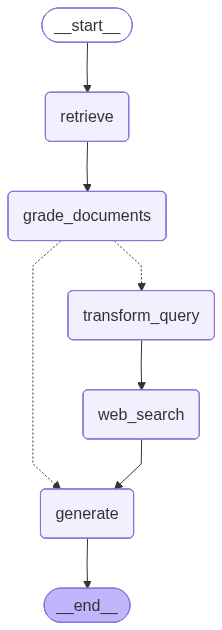



-------------Graphe compilé et visualisé---------------


In [17]:
from langgraph.graph import START,StateGraph,END
from IPython.display import display,Image


#definir le graphe
workflow=StateGraph(GraphState)

#definir les noeuds
workflow.add_node("retrieve",retrieve) #noeud de recuperation
workflow.add_node("generate",generate) #noeud de generation
workflow.add_node("grade_documents",grade_documents) #noeud d'evaluation
workflow.add_node("transform_query",transform_query) #noeud de transformation
workflow.add_node("web_search",web_search) #noeud de recherche web

#Construire le graphe
workflow.add_edge(START,"retrieve")
workflow.add_edge("retrieve","grade_documents")
workflow.add_conditional_edges(
    "grade_documents",decide,
    {
        "transform_query":"transform_query",
        "generate":"generate"
    }
)
workflow.add_edge("transform_query","web_search")
workflow.add_edge("web_search","generate")
workflow.add_edge("generate",END)


#compiler
app=workflow.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png()))
print("\n\n-------------Graphe compilé et visualisé---------------")


In [23]:
#Executer l'application de type correctif RAG avec une question

input_state={
    "question": "liste quelque maladies infectieuses et les sympotomes?"
}

#Invoquer le graphe
result=app.invoke(input_state)
#afficher la question
print("Question: \n", input_state["question"])

#afficher la reponse finale

print("\n\n--------Execution de l'application terminé----------")
print("\nRéponse finale: \n", result.get("generation","").strip())

#afficher la question éventuellement reformulée
print("\nQuestion reformulée: \n", result.get("question","").strip())


#Collecter les sources (retriever + recher web)
def extract_source(md: dict) -> str:
  if not md:
    return ""
  return md.get("source") or md.get("title") or md.get("url") or ""

# Initialize seen and sources outside the function and before the loop
seen = set()
sources = []
for doc in result.get("documents",[]):

  source=extract_source(getattr(doc,"metadata",{}))
  if source not in seen:
    seen.add(source)
    sources.append(source)
print("\n Source :")
if sources :
  for s in sources :
    print(f"- {s}")
else:
  print("Aucun méta donné de source disponible ")

-------------Récupération---------------
4 documents récupérés
-------------Evaluation de la pertinence des documents récupérés ---------------


/usr/local/lib/python3.12/dist-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=GradeDocuments(binary_score='yes'), input_type=GradeDocuments])
  return self.__pydantic_serializer__.to_python(


-----Document pertient trouvé : Tabular_list_of_deseases.pdf------ 
-----Document pertient trouvé : Tabular_list_of_deseases.pdf------ 
-----Document pertient trouvé : Tabular_list_of_deseases.pdf------ 
-----Document pertient trouvé : Tabular_list_of_deseases.pdf------ 
-------------Décision ---------------
----DECISION : DOCS PERTINENTS --> GENERER LA REPONSES----
-------------Génération---------------
Question: 
 liste quelque maladies infectieuses et les sympotomes?


--------Execution de l'application terminé----------

Réponse finale: 
 Voici quelques maladies infectieuses et leurs symptômes : l'amebiasis peut causer des douleurs abdominales et de la diarrhée, la candidiasis peut entraîner une levure buccale ou vaginale, et la tuberculose pulmonaire provoque une toux persistante et une perte de poids. Les symptômes varient selon la maladie, mais comprennent souvent des troubles digestifs, des éruptions cutanées ou des signes généraux d'infection.

Question reformulée: 
 liste que